# Assignment 6

In [2]:
1+1

2

In [6]:
from chainer import Chain
import chainer.links as L
import chainer.functions as F


class GenerativeMLP(Chain):
	def __init__(self, n_hidden):
		super(GenerativeMLP, self).__init__()
		with self.init_scope():
			self.fc1 = L.Linear(None, n_hidden)  # Fully Connected Layer
			self.fc2 = L.Linear(n_hidden, n_hidden)
			self.fc3 = L.Linear(n_hidden, 28*28)

	def __call__(self, x):
		fc1_out = F.elu(self.fc1(x))
		fc2_out = F.sigmoid(self.fc2(fc1_out))
		fc3_out = self.fc3(fc2_out)
		return fc3_out


class Generative(Chain):
	def __init__(self, n_hidden):
		super(Generative, self).__init__()
		with self.init_scope():
			self.fc = L.Linear(None, n_hidden)  # Fully Connected Layer
			self.bn = L.BatchNormalization(n_hidden)  # Batch Normalisation Computation
			self.deconv = L.Deconvolution2D(None, 28*28, 4, 2, 1)  # Deconvolutional Layer

	def __call__(self, x):
		fc_output = self.fc(x)
		batch_norm = self.bn(fc_output)
		deconv_output = F.sigmoid(self.deconv(batch_norm))

		return deconv_output


class DiscriminativeMLP(Chain):
	def __init__(self, n_hidden):
		super(DiscriminativeMLP, self).__init__()
		with self.init_scope():
			self.fc1 = L.Linear(784, n_hidden)  # Fully Connected Layer
			self.fc2 = L.Linear(n_hidden, n_hidden)
			self.fc3 = L.Linear(n_hidden, 2)

	def __call__(self, x):
		fc1_out = F.elu(self.fc1(x))
		fc2_out = F.elu(self.fc2(fc1_out))
		fc3_out = F.sigmoid(self.fc3(fc2_out))
		return fc3_out


class Discriminative(Chain):
	def __init__(self, n_feature_maps=5, ksize=5):
		super(Discriminative, self).__init__()
		with self.init_scope():
			self.conv = L.Convolution2D(1, n_feature_maps, ksize=ksize)  # Convolutional Layer
			self.lin = L.Linear(None, 1)  # Linear Readout Layer

	def __call__(self, x):
		conv_output = F.relu(self.conv(x))
		lin_output = self.lin(conv_output)

		return lin_output


100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


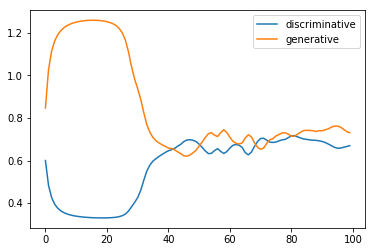

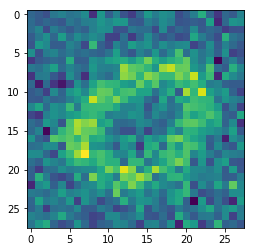

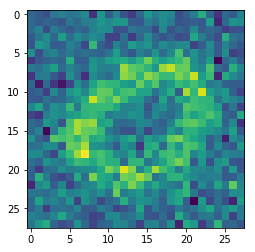

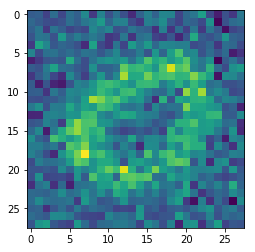

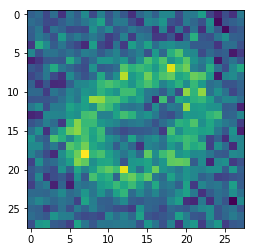

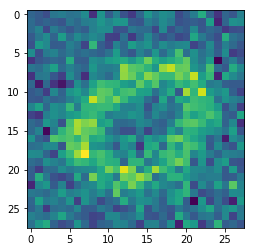

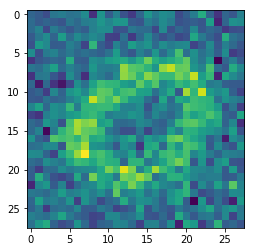

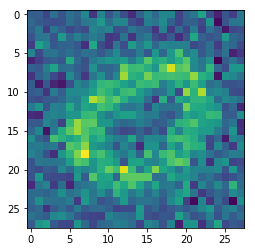

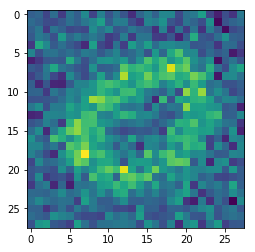

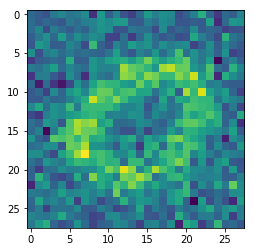

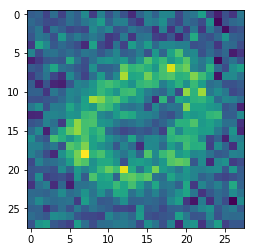

In [15]:
import chainer.functions as F
import chainer.optimizers as optimizers
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import networks
from Model import Model
from utils import get_mnist, RandomIterator


def train():
	loss_disc = []
	loss_gen = []
	for _ in tqdm(range(n_iter)):
		loss_disc_current = 0
		loss_gen_current = 0
		for data in train_iter:
		
			x_real = data
			t_real = discriminative_net(x_real)

			gen_input = np.float32(np.random.uniform(size=(batch_size, 1)))
			x_fake = generative_net(gen_input)
			t_fake = discriminative_net(x_fake)

			# generative_loss = F.log(t_fake)
			

			# Backprop
			generative_loss = F.softmax_cross_entropy(t_fake, np.ones(shape=(batch_size), dtype=np.int32))
			discriminative_loss = F.softmax_cross_entropy(t_fake, np.zeros(shape=(batch_size), dtype=np.int32))
			discriminative_loss += F.softmax_cross_entropy(t_real, np.ones(shape=(batch_size), dtype=np.int32))
			discriminative_loss /= 2
			
			generative_net.cleargrads()
			generative_loss.backward() # recompute the grads
			generative_optimizer.update()

			discriminative_net.cleargrads()
			discriminative_loss.backward()
			discriminative_optimizer.update()

			loss_disc_current += discriminative_loss.data
			loss_gen_current += generative_loss.data

		loss_gen.append(loss_gen_current/train_iter.idx)
		loss_disc.append(loss_disc_current/train_iter.idx)

	gen_input = np.float32(np.random.uniform(size=[1, 1]))
	generation = generative_net(gen_input)  # we need to keep the variable type around, to compute stuff

	plt.plot(loss_disc, label="discriminative")
	plt.plot(loss_gen, label="generative")
	plt.legend()
	plt.show()
	for i in range(10):
		gen_input = np.float32(np.random.uniform(size=[1, 1]))
		generation = generative_net(gen_input)  # we need to keep the variable type around, to compute stuff

		plt.imshow(np.reshape(generation.data, newshape=[28, 28]).transpose())
		plt.show()
	# plt.show()



if __name__ == "__main__":
	n_iter = 100
	batch_size = 50
	train_data, test_data = get_mnist(n_train=1000, n_test=100, with_label=False, classes=[0], n_dim=3)
	train_iter = RandomIterator(train_data, batch_size)
	test_iter = RandomIterator(test_data, batch_size)

	discriminative_net = networks.DiscriminativeMLP(n_hidden=100)
	generative_net = networks.GenerativeMLP(n_hidden=100)

	discriminative_optimizer = optimizers.SGD()
	discriminative_optimizer.setup(discriminative_net)

	generative_optimizer = optimizers.SGD()
	generative_optimizer.setup(generative_net)
	

	train()


# 0
Hoe de nullen er nu uitzien.

### Loss

We can see that there is a strong negative correlation between the losses, which is expected.

### MLP network
Als we naar de plaatjes kijken, dan zien we dat de contouren van de nullen duidelijk zichtbaar zijn. Het is echter ook duidelijk dat dit geen handgeschreven nullen zijn, gezien de hoeveelheid ruis die nu zichtbaar is in het plaatje.

Iets anders dat opvalt is dat het generative network veel meer units nodig heeft, dit is niet verrassend, het genereren van een plaatje is complexer dan het herkennen van het plaatje. Dit heeft echter tot gevolg dat het snel voorkomt dat het discriminatieve netwerk te goed wordt, en het creeerende netwerk geen goede plaatjes meer kan maken, en zich dus niet meer kan verbeteren.

# comment! REMOVE 

het netwerk werkt niet met 
10 vs 50

het best met 
10 vs 100

minder goed (op het oog)
10 vs 200
# end comment! REMVOE

### Convolutional
